In [40]:
PATH <- file.path("C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project") #"/home/andewegs/1_RSV_scripts/"
setwd(PATH)
#getwd()
library(tidyverse)
rsv.data <- read_csv(file = "Data/infection_status.csv")

Rows: 682 Columns: 23
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl  (20): age_days, infection, IgG_PreF, IgA_PreF, IgG_PostF, IgA_PostF, Ig...
lgl   (1): IgA_Nn_household
date  (2): birthday, consultdate

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [41]:
#get true number of infected and recovered children
rsv_by_age <- rsv.data %>% arrange(age_days)
tab <- table(rsv_by_age$age_days, rsv_by_age$infection)
true_hist <- data.frame(age=rownames(tab), infected=tab[,2])
true_hist$age <- as.numeric(true_hist$age)
true_hist$cuminfection <- cumsum(true_hist$infected
tail(true_hist)

,age,infected,cuminfection
,<dbl>,<int>,<int>
1808,1808,1,339
1821,1821,1,340
1823,1823,1,341
1841,1841,2,343
1843,1843,1,344
1854,1854,1,345


In [42]:
#add susceptible
N <- nrow(rsv_by_age)
true_hist$susceptible <- N - true_hist$cuminfection
tail(true_hist)

,age,infected,cuminfection,susceptible
,<dbl>,<int>,<int>,<int>
1808,1808,1,339,343
1821,1821,1,340,342
1823,1823,1,341,341
1841,1841,2,343,339
1843,1843,1,344,338
1854,1854,1,345,337


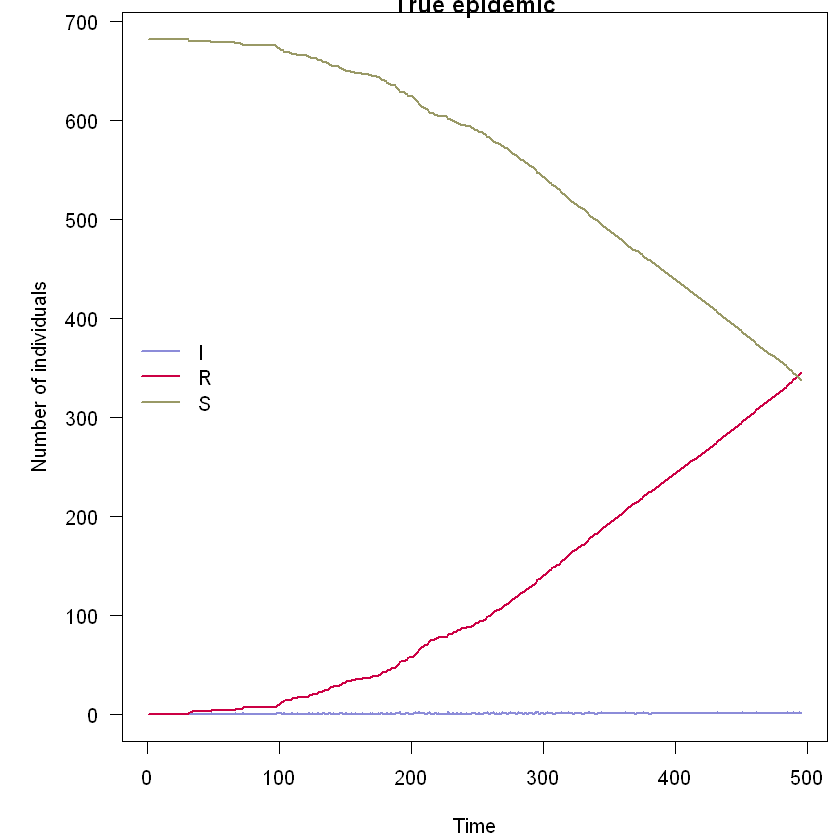

In [38]:
#png("true epidemic.png")
cols <- names(true_hist) %in% c('age')
hist_no_time <- true_hist[!cols]
par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
cols <- c(I = "#8c8cd9", R = "#cc0044", S = "#999966")
matplot(hist_no_time, type = "l", 
        xlab = "Time", ylab = "Number of individuals",
        col = cols, lty = 1, lwd = 2)
legend("left", lwd = 2, col = cols, legend = names(cols), bty = "n")
title("True epidemic", line = 0)
#dev.off()

Now mcstate

In [44]:
#define a dataframe with all days between the youngest age and the oldest age
min = head(dframe$age,1)
max = tail(dframe$age,1)
days <- seq(min, max)
infections <- rep(0, max-min+1)

df <- data.frame(days, infections)

In [45]:
rsv_by_age <- rsv.data %>% arrange(age_days)
tab <- table(rsv_by_age$age_days, rsv_by_age$infection)
dframe <- data.frame(age=rownames(tab), infected=tab[,2])
dframe$age <- as.numeric(dframe$age)
dframe$cuminfection <- cumsum(dframe$infected)

In [47]:
tail(dframe)

,age,infected,cuminfection
,<dbl>,<int>,<int>
1808,1808,1,339
1821,1821,1,340
1823,1823,1,341
1841,1841,2,343
1843,1843,1,344
1854,1854,1,345


In [48]:
for (d in seq_along(df$days))
    for (a in seq_along(dframe$age))
     if (df$days[d] == dframe$age[a])
         df$infections[d] <- dframe$infected[a]

In [50]:
dt <- 1
sir_data <- mcstate::particle_filter_data(data = df,
                                          time = "days",
                                          rate = 1 / dt)
head(rmarkdown::paged_table(sir_data))

,days_start,days_end,step_start,step_end,infections
,<int>,<int>,<int>,<int>,<dbl>
1,35,36,35,36,0
2,36,37,36,37,0
3,37,38,37,38,0
4,38,39,38,39,0
5,39,40,39,40,0
6,40,41,40,41,0


In [61]:
case_compare <- function(state, observed, pars = NULL) {
  exp_noise <- 1e6

  incidence_modelled <- state[4 , drop = TRUE]
  incidence_observed <- observed$infections
  lambda <- incidence_modelled +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = incidence_observed, lambda = lambda, log = TRUE)
}

In [52]:
incidence_compare <- function(state, prev_state, observed, pars = NULL) {
  exp_noise <- 1e6

  lambda <- state[4, , drop = TRUE] +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = observed$infections, lambda = lambda, log = TRUE)
}

In [53]:
nrow(rsv_by_age)

[1] 682

In [57]:

setwd("C:/Users/julia")
getwd()

[1] "C:/Users/julia"

In [66]:
#model with S = 682
library(odin.dust)
gen_sir <- odin.dust::odin_dust("sir.R")
sir_model <- gen_sir$new(pars = list(dt = 1,
                                     S_ini = 681,
                                     I_ini = 1,
                                     beta = 0.2,
                                     gamma = 0.1),
                         step = 1,
                         n_particles = 10L,
                         n_threads = 4L,
                         seed = 1L)

Using cached model



In [69]:
n_particles <- 10L
filter <- mcstate::particle_filter$new(data = sir_data,
                                       model = gen_sir,
                                       n_particles = n_particles,
                                       compare = case_compare,
                                       seed = 1L)

In [70]:
filter$run(save_history = TRUE, pars = list(dt = dt))

ERROR: Error: Expected a vector of length 10 for 'index' but given 1
